In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import skewnorm
from scipy.stats import truncnorm
from scipy.stats import lognorm
import time
import sys

In [445]:
class Project:
    def __init__(self, 
                 numClients=8000, 
                 numInvestments=10000, 
                 numDays=365, 
                 minNumDeposits=2, 
                 maxNumDeposits=10,
                 maxDepositeAmount=5e7,
                 beta=0.1,
                 randomYieldPeriod=None
                ):
        
        self._numClients = numClients
        self._numInvestments = numInvestments
        self._numDays = numDays
        self._minNumDeposits = minNumDeposits
        self._maxNumDeposits = maxNumDeposits
        self._maxDepositeAmount = maxDepositeAmount
        self._beta = beta
        self._randomYieldPeriod = randomYieldPeriod
        self._totalPrincipal = 0
        self._totalBalance = 0
        self._totalShare = 0
        self._day = 0
        
        # ----------------------------------------------------------------------------
        # Preallocate numpy arrays that will be used in the simulation
        # I will mainly take a record of client and investment balance for each day
        # These records will be enough to reconstruct every detail when needed
        # client_share represent their share of contributions to the pool of interests
        # ----------------------------------------------------------------------------
        
        # Investment side
        self.investment_yield = np.zeros(self._numInvestments, dtype=np.float)
        self.investment_capacity = np.zeros(self._numInvestments, dtype=np.float)
        self.investment_daily_principal = np.zeros((self._numInvestments, self._numDays), dtype=np.float)
        self.investment_daily_balance = np.zeros((self._numInvestments, self._numDays), dtype=np.float)
        
        # Client side
        self.client_max_principal = np.zeros(self._numClients, dtype=np.float)
        self.client_daily_principal = np.zeros((self._numClients, self._numDays), dtype=np.float)
        self.client_daily_balance = np.zeros((self._numClients, self._numDays), dtype=np.float)
        self.client_daily_share = np.zeros((self._numClients, self._numDays), dtype=np.float)
        self.daily_total_principal = np.zeros(self._numDays, dtype=np.float)
        self.daily_total_balance = np.zeros(self._numDays, dtype=np.float)
        self.daily_total_share = np.zeros(self._numDays, dtype=np.float)
        self.daily_moneyio = np.zeros(self._numDays, dtype=np.float)
        
        # ---------------------------------------------
        # Simulation:
        # Generate investments and clients
        # Assume investments follow normal distribution
        # while clients follow lognormal distribution
        # ---------------------------------------------
        scale = 5
        self.investment_capacity[:] = np.round((truncnorm.rvs(-24/scale, 25/scale, loc=25, scale=scale, 
                                                              size=self._numInvestments, random_state=self._seed()) * 1e6), 0)
        self.client_max_principal[:] = np.round(lognorm.rvs(0.4, loc=1, scale=8.3, 
                                                              size=self._numClients, random_state=self._seed()) * 1e6, 0)
        self.client_max_principal[self.client_max_principal > self._maxDepositeAmount] = self._maxDepositeAmount
        
        # ----------------------------------------------------------------
        # Simulation:
        # Generate details of deposites each day
        # Number of Deposites is uniformly distributed within each day
        # Each deposite can come from any client with the same probability
        # Note: Withdrawals will be generated along with the simulation
        # ----------------------------------------------------------------
        self.daily_num_deposites = np.random.randint(self._minNumDeposits, self._maxNumDeposits + 1, size=self._numDays)
        self.deposite_clientId = np.random.choice(self._numClients, size=np.sum(self.daily_num_deposites))
        clients_who_deposite, counts_per_client = np.unique(self.deposite_clientId, return_counts=True)
        self.deposite_amount = self.client_max_principal.copy()
        self.deposite_amount[clients_who_deposite] /= counts_per_client
        self.daily_deposite_start_index = np.roll(np.cumsum(self.daily_num_deposites), 1)
        self.daily_deposite_start_index[0] = 0
        self.daily_deposite_end_index = np.cumsum(self.daily_num_deposites)
    
    
    
    # --------------------------      
    # Helper
            
    def _seed(self):
        return int(time.time()%1 * 1e6)

    
    
    # --------------------------      
    # Methods (investment side)

    def _genYieldRate(self):
        # -------------------------------------------------
        # Yearly yield follows a skewed normal distribution
        # We could add correlation later if needed
        # -------------------------------------------------
        self.investment_yield[:] = skewnorm.rvs(5, loc=20, scale=26, size=self._numInvestments, random_state=self._seed()) * 1e-4
        self.investment_yield[self.investment_yield < 0.0001] = 0.0001
        self.investment_yield[self.investment_yield > 0.0150] = 0.0150
        
        
    def _updateOvernight(self):
        # Update investment balance
        self.investment_daily_principal[:, self._day] = self.investment_daily_principal[:, self._day-1]
        self.investment_daily_balance[:, self._day] = self.investment_daily_balance[:, self._day-1] * (1 + self.investment_yield / 365)
        self._totalBalance = np.sum(self.investment_daily_balance[:, self._day])   

        self.daily_total_balance[self._day] = self._totalBalance
        self.daily_total_principal[self._day] = self._totalPrincipal

        # -----------------------------------------------------------------------------------------------------------------------
        # Update client balance
        # To save memory, we do not store detailed client-investment balance each day
        # Instead, we can assume that there is no difference between each client other than their invested money
        # This way, their principals in each investment is proportional to the ratio between client principal and total principal
        # while their profits is proportional to sum(client principal(t)) (which is called "client_daily_share")
        # -----------------------------------------------------------------------------------------------------------------------
        self.client_daily_principal[:, self._day] = self.client_daily_principal[:, self._day-1]
        self.client_daily_share[:, self._day] += self.client_daily_principal[:, self._day] + self.client_daily_share[:, self._day-1]
        self._totalShare = np.sum(self.client_daily_share[:, self._day])
        self.daily_total_share[self._day] = self._totalShare
        self.client_daily_balance[:, self._day] = (self.client_daily_principal[:, self._day] 
                                                   + (self._totalBalance - self._totalPrincipal) 
                                                      * self.client_daily_share[:, self._day] / self._totalShare)
        
        
    def _allocate(self):
        # --------------------------------------------------------------------------------------------
        # We can prioritize saturating those investments with higher yield
        # --------------------------------------------------------------------------------------------
        # First, we need to make sure clients money is less than 200k in each investment
        # We can rank the investment based on their yield and calculte how many 'good' investments
        # is needed to be enough to distribute clients' cash properly
        # --------------------------------------------------------------------------------------------
        money_in = self._totalBalance - np.sum(self.investment_daily_balance[:, self._day])
        remaining_capacity = self.investment_capacity - self.investment_daily_balance[:, self._day]
        maxClientRatio = np.max(self.client_daily_balance[:, self._day]) / np.sum(self.client_daily_balance[:, self._day])
        yield_rank = np.argsort(self.investment_yield)[::-1]
        minNumInvestments = np.sum((pd.Series(remaining_capacity[yield_rank]).cummax().values 
                                        / np.cumsum(remaining_capacity[yield_rank])) 
                                   > (2e5 / (maxClientRatio * self._totalBalance))) + 1
        
        # Then, we need to calculate the minimum number of investments so that we can at least have enough capacity.
        target_num_investments = max(int(np.sum(np.cumsum(remaining_capacity[yield_rank]) < money_in)) + 1, minNumInvestments)
        
        # Now, we allocate money into investments
        total_remaining_capacity = np.sum(remaining_capacity[yield_rank[:target_num_investments]])
        investmentId_to_allocate = yield_rank[:target_num_investments]
        self.investment_daily_balance[investmentId_to_allocate, self._day] += (remaining_capacity[investmentId_to_allocate]
                                                                               * money_in / total_remaining_capacity)
        self.investment_daily_principal[investmentId_to_allocate, self._day] += (remaining_capacity[investmentId_to_allocate]
                                                                                 * money_in / total_remaining_capacity)
    
        
    def _rebalance(self):
        # --------------------------------------------------------------------------------------------
        # We can rebalance the portfolio to maximize average yield
        # I propose to use decay as smoothing technics which works well with moderate profit lose
        # --------------------------------------------------------------------------------------------
        # First, we need to make sure clients money is less than 200k in each investment
        # We can rank the investment based on their yield and calculte how many 'good' investments
        # is needed to be enough to distribute clients' cash properly
        # --------------------------------------------------------------------------------------------
        maxClientRatio = np.max(self.client_daily_balance[:, self._day]) / np.sum(self.client_daily_balance[:, self._day])
        yield_rank = np.argsort(self.investment_yield)[::-1]
        minNumInvestments = np.sum((pd.Series(self.investment_capacity[yield_rank]).cummax().values 
                                        / np.cumsum(self.investment_capacity[yield_rank])) 
                                   > (2e5 / (maxClientRatio * self._totalBalance))) + 1

        # Then, we need to calculate the minimum number of investments so that we can at least have enough capacity.
        target_num_investments = max(np.sum(np.cumsum(self.investment_capacity[yield_rank]) < self._totalBalance) + 1, minNumInvestments)
        
        # Now, we generate new balances for each investment with decay
        target_balance = np.zeros(self._numInvestments, dtype=np.float)
        target_balance[yield_rank[:target_num_investments]] = self.investment_capacity[yield_rank[:target_num_investments]]
        adjusted_balance = self._beta * target_balance
        if np.sum(self.investment_daily_balance[:, self._day]) > 0:
            adjusted_balance += (1 - self._beta) * self.investment_daily_balance[:, self._day]

        self.investment_daily_balance[:, self._day] = adjusted_balance * self._totalBalance / np.sum(adjusted_balance)
        
        self.investment_daily_principal[:, self._day] = (self._totalPrincipal * self.investment_daily_balance[:, self._day] 
                                                                              / self._totalBalance)

        
    # --------------------------      
    # Methods (client side)
        
    def _deposite(self):
        # Add deposites to client accounts
        start = self.daily_deposite_start_index[self._day]
        end = self.daily_deposite_end_index[self._day]
        self.client_daily_principal[self.deposite_clientId[start: end], self._day] += self.deposite_amount[start: end]
        self.client_daily_balance[self.deposite_clientId[start: end], self._day] += self.deposite_amount[start: end]
        self._totalPrincipal = np.sum(self.client_daily_principal[:, self._day])
        self._totalBalance = np.sum(self.client_daily_balance[:, self._day])
        self.daily_moneyio[self._day] += np.sum(self.deposite_amount[start: end])
    
    def _withdrawal(self):
        # ------------------------------------------------------------------------
        # Add withdrawals on Monday
        # To simplify the simulation, we assume each existing client each day will 
        # have a 0.2% chance to initiate a withdrawal of all the money
        # ------------------------------------------------------------------------
        clientId_withdrawal = np.arange(self._numClients)
        clientId_withdrawal[np.random.random(self._numClients) > 0.002] = -1
        clientId_withdrawal[self.client_daily_balance[:, self._day] == 0] = -1
        clientId_withdrawal = clientId_withdrawal[clientId_withdrawal >= 0]
        self.daily_moneyio[self._day] -= np.sum(self.client_daily_balance[clientId_withdrawal, self._day])
        self.client_daily_principal[clientId_withdrawal, self._day] = 0
        self.client_daily_balance[clientId_withdrawal, self._day] = 0
        self._totalPrincipal = np.sum(self.client_daily_principal[:, self._day])
        self._totalBalance = np.sum(self.client_daily_balance[:, self._day])
        
        

    # --------------------------      
    # Main loop
    
    def run(self):
        
        self._day = 0
        self._genYieldRate()
        while self._day < self._numDays:
            
            if self._randomYieldPeriod and self._day%self._randomYieldPeriod == 0: 
                self._genYieldRate()
                
            if self._day != 0: 
                self._updateOvernight() 
                
            self._deposite()
            
            if self._day%7 == 0:
                self._withdrawal()
                self._rebalance()
            else:
                self._allocate()

            self._day += 1
          
    
    
    # --------------------------      
    # APIs
    
    def historicalBalance(self, clientId=None, investmentId=None):
        # -------------------------------------------------------------------------------
        # Function to retrive historical client-investment balance over time
        # If only one type of Id is given, function will return aggregated result
        # If no Id present, function will return the entire portfolio
        # clientId and investmentId can be an integer or a list depending on the use case
        # Return type: pandas.DataFrame/pandas.Series
        # -------------------------------------------------------------------------------
        if clientId != None and investmentId != None:
            if type(clientId) == int and type(investmentId) == int:
                return pd.Series((self.investment_daily_balance[investmentId, :] * self.client_daily_balance[clientId, :] 
                                                                                 / self.daily_total_balance),
                                 name=str(clientId) + '_' + str(investmentId))
        
        elif clientId != None:
            if type(clientId) == int: clientId = [clientId]
            return pd.DataFrame(self.client_daily_balance[sorted(clientId)].T, 
                                columns=['client_' + str(Id) for Id in sorted(clientId)])
        
        elif investmentId != None:
            if type(investmentId) == int: investmentId = [investmentId]
            return pd.DataFrame(self.investment_daily_balance[sorted(investmentId)].T, 
                                columns=['investment_' + str(Id) for Id in sorted(investmentId)])
        
        else:
            return pd.Series(self.daily_total_balance, name='balance')
        
    
    def clientInvestmentBalance(self, day=-1):
        # Function to output detailed cash distribution on any given day (default: current day)
        return pd.DataFrame((self.investment_daily_balance[:, day].reshape(1, -1) * self.client_daily_balance[:, day].reshape(-1, 1) 
                                                                                  / self.daily_total_principal[day]),
                            index=['client_' + str(Id) for Id in range(self._numClients)], 
                            columns=['investment_' + str(Id) for Id in range(self._numInvestments)])

In [450]:
%time simulation = Project(randomYieldPeriod=30)
%time simulation.run()

Wall time: 13 ms
Wall time: 1.11 s


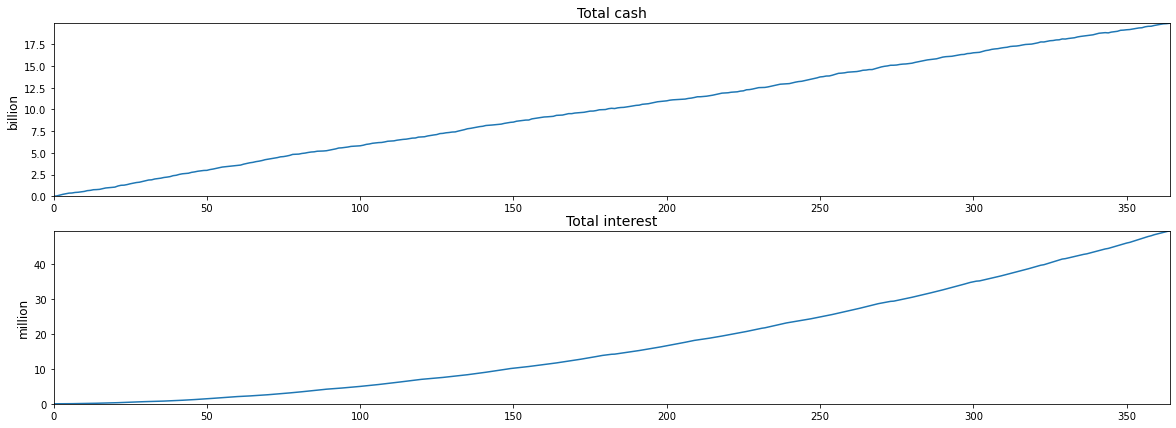

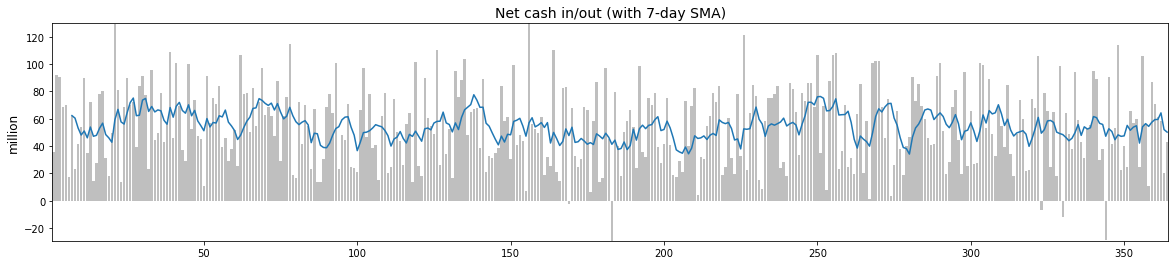

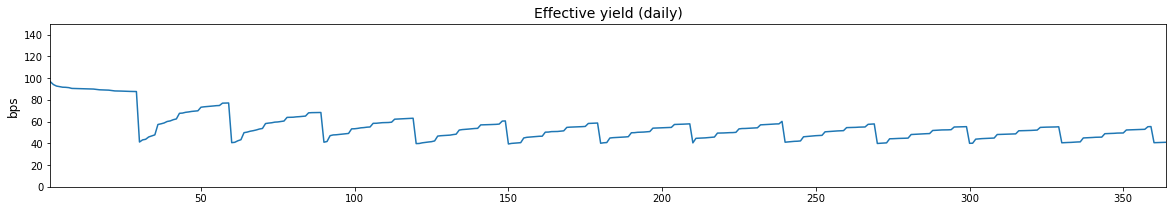

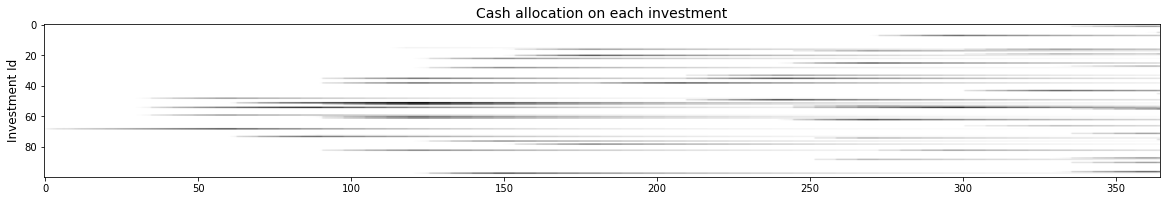

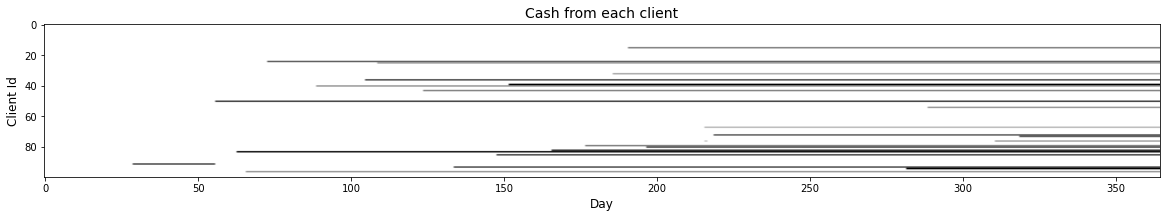

In [451]:
plt.figure(figsize=(20, 7))
plt.subplot(211)
plt.plot(simulation.daily_total_balance / 1e9)
plt.ylabel('billion', fontsize=12)
plt.title('Total cash', fontsize=14)
plt.margins(0)
plt.subplot(212)
plt.plot((simulation.daily_total_balance - simulation.daily_total_principal) / 1e6)
plt.ylabel('million', fontsize=12)
plt.title('Total interest', fontsize=14)
plt.margins(0)
plt.show()

plt.figure(figsize=(20, 4))
plt.bar(np.arange(365), pd.Series(simulation.daily_total_balance).diff() / 1e6, color='grey', alpha=0.5)
plt.plot(pd.Series(simulation.daily_total_balance).diff().rolling(7).mean() / 1e6)
plt.ylabel('million', fontsize=12)
plt.title('Net cash in/out (with 7-day SMA)', fontsize=14)
plt.margins(0)
plt.show()

plt.figure(figsize=(20, 3))
(1e4*365*(pd.Series(simulation.daily_total_balance).diff() 
          - pd.Series(simulation.daily_moneyio).shift(1))/pd.Series(simulation.daily_total_balance)).plot()
plt.ylabel('bps', fontsize=12)
plt.title('Effective yield (daily)', fontsize=14)
plt.ylim(0, 150)
plt.margins(0)
plt.show()

plt.figure(figsize=(20, 7))
plt.imshow(simulation.investment_daily_balance[:100], aspect=0.5, cmap='binary')
plt.ylabel('Investment Id', fontsize=12)
plt.title('Cash allocation on each investment', fontsize=14)

plt.figure(figsize=(20, 7))
plt.imshow(simulation.client_daily_balance[:100], aspect=0.5, cmap='binary')
plt.ylabel('Client Id', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.title('Cash from each client', fontsize=14)
plt.show()